# TensowFlow のチュートリアル
## For ML Beginner
参考
* http://qiita.com/haminiku/items/36982ae65a770565458d
* http://www.tensorflow.org/tutorials/mnist/beginners/index.html
 * official

## 準備
* 事前にMNISTのデータを取得するためのclassを作っておく必要がある
* チュートリアルにあるし、GoogleのGitからDL出来るかも
 * GoogleGitがよくわからなかったから、ブラウザで開いて、テキストをコピペしてきたけど
* https://tensorflow.googlesource.com/tensorflow/+/master/tensorflow/g3doc/tutorials/mnist/input_data.py
 * コードは↑
 * input_data.py というファイル名で保存

### 確認
* 上記のクラスの動作を確認する

```
$ python

> import input_data
> mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
```


## チュートリアルをやってみる

### パッケージのインポート
まずは、必要なパッケージをインポートする。

事前にtensorflowのインストールと確認は済ませておくように。

In [1]:
from __future__ import absolute_import, unicode_literals
import input_data
import tensorflow as tf

## 学習結果の描画に使う
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### MNISTデータのダウンロード
* ↑で作ったclassを使って、データをダウンロードする
* 実行ディレクトリに「MNIST_data」というディレクトリができて、その中にデータが格納される

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### MNISTデータを確認する
* 落としてきたデータを確認してみる
* 手書き文字なので、けっこうひどいものが含まれてるのが確認できる

In [3]:
size = 28
col = 5
row = 3
plt.figure(figsize=(20, 3))

# 描画用の関数
def draw_digit(data, n, ans, recog):
    plt.subplot(row, col, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # 見やすいように反転させる
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(Z)  # 指定座標(X,Y)にカラープロット(色=Z)する
    plt.title("ans=%d, recog=%d"%(ans,recog), size=8)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

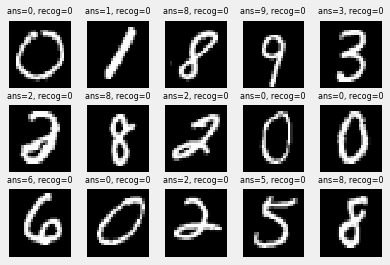

In [4]:
plt.style.use('fivethirtyeight')
N = len(mnist.train.images)
cnt = 0
for idx in np.random.permutation(N)[:col*row]:
    cnt+=1
    draw_digit(mnist.train.images[idx], cnt, np.argmax(mnist.train.labels[idx]), 0)
plt.show()

上記のデータを学習データとして、文字認識するためのモデルを定義し、学習させて行こう。

### モデルの定義
* ここでは、単純なソフトマックス回帰を扱う
 * つまり、deepでもないし、Neural-Networでもない（単層NNと等価ではある）
* 入力は28×28ピクセルの画像データ（784次元のベクトル）
 * 各ピクセルは0~1に正規化されている
* 出力は、0~9の各文字の判別確率
 * softmax関数で確率化している


In [5]:
## 入力
x = tf.placeholder("float", [None, 784])
### Noneはサイズを決めないということ
## 重み
W = tf.Variable(tf.zeros([784,10]))
## バイアス
b = tf.Variable(tf.zeros([10]))
## 出力
y = tf.nn.softmax(tf.matmul(x,W) + b)

### 訓練
#### コスト関数
* コスト関数を決めないといけない
 * 普通にcross-entropyを使う（下記）
$$ H_{y'} (y) = - \sum_{i} y'_i \log(y_i) $$
 $y$:推定確率分布、$y'$:真の確率分布

In [6]:
# まずは真の分布を格納するための箱を用意する
y_ = tf.placeholder("float", [None,10])
# cross-entropyを定義する
cross_entropy = - tf.reduce_sum(y_*tf.log(y))

####  backpropagation algorithmの設定

In [7]:
# 勾配法で最適化する
# 学習係数は0.01
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

#### 学習変数の初期化

In [8]:
init = tf.initialize_all_variables()

#### セッションの初期化
* ちょっと時間かかる

In [33]:
sess = tf.Session()
sess.run(init)

#### 1000回学習させる
* ミニバッチのサイズは100
* 確率的勾配法（SGD）で学習する
* 学習回数は1000回

* 【メモ】
 * 計算途中のaccuracyは出せないのかな?訓練データに対するaccuracyは別に計算しないといけない?

In [27]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

test_step = []
test_acc  = []
sess.run(init)

train_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print "initial_accuracy = %s"%train_accuracy # 初期の精度は0.1くらいになる(10個の数字をランダムに答えるのと一緒だから)
test_step.append(0)
test_acc.append(train_accuracy)

# 学習のループを回す
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(10)
    if i%10 == 0:
        idxs = np.random.permutation(len(mnist.test.images))[:1000] # 1000枚のテスト画像を使って精度を計算する
        train_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images[idxs,], y_: mnist.test.labels[idxs,]})
        test_step.append(i+1)
        test_acc.append(train_accuracy)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

initial_accuracy = 0.098


#### 結果の表示
* tf.argmax(y,1) : 確率が最大のラベルを返す
* tf.equal : 引数が一致するかを確認する関数


In [12]:
# 正解数のカウント
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
# tf.equalの戻り値はboolean型なので、キャストする
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
# testデータに対する正解率
print sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.8945


#### 精度の変化を確認
* 学習ステップ毎の精度をグラフにして表示する

(-10, 991)

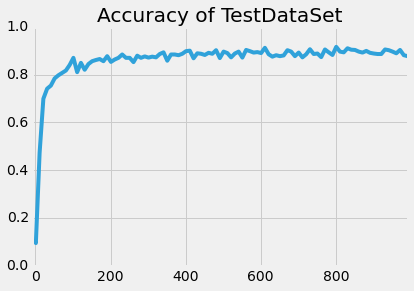

In [32]:
plt.plot(test_step, test_acc)
plt.title("Accuracy of TestDataSet")
plt.xlim(-10, np.max(test_step))

### 学習結果の確認
#### 学習結果として得られたモデルを使って、文字認識させてみる

* テストデータを一つずつ入力して、結果を返すってのをもっとスマートに出来ないもんか？

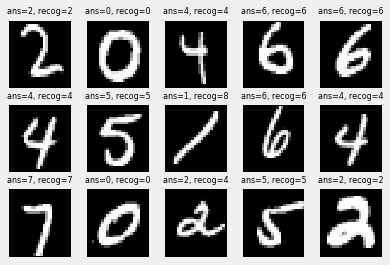

In [13]:
plt.style.use('fivethirtyeight')
N = len(mnist.test.images)
cnt = 0
for idx in np.random.permutation(N)[:col*row]:
    rec = sess.run(tf.argmax(y,1), feed_dict={x: mnist.test.images[idx:idx+1,], y_: mnist.test.labels[idx:idx+1,]})
    cnt+=1
    draw_digit(mnist.test.images[idx], cnt, np.argmax(mnist.test.labels[idx]), rec)
plt.show()
